In [1]:
#importing the required stuff

from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [2]:
%matplotlib inline
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [3]:
# set number of assets (= number of qubits)
num_assets = 10
seed = 1234
#### Using data from yahoo finance
data = YahooDataProvider(
        tickers= ["JPM", "GS", "MSFT", "AAPL", "CO", "WMT", "DIS", "BA", "MCD", "NKE"],
        start=datetime.datetime(2011, 1, 1),
        end=datetime.datetime(2020, 12, 31),
    )
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


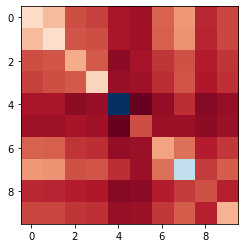

In [4]:
# plot sigma
plt.imshow(sigma, interpolation="nearest", cmap = "RdBu")
plt.show()


In [5]:
print(mu)
print('\n')
print(sigma)

[0.00070354 0.00040367 0.0010463  0.00119462 0.00036325 0.00056174
 0.00080103 0.00082355 0.00059409 0.00093546]


[[3.29455221e-04 2.82433803e-04 1.48569058e-04 1.33988727e-04
  8.00360146e-05 6.81020208e-05 1.73211895e-04 2.37108370e-04
  1.04173392e-04 1.40987222e-04]
 [2.82433803e-04 3.40839853e-04 1.56368851e-04 1.48629194e-04
  7.88781092e-05 6.71104412e-05 1.69904545e-04 2.30175971e-04
  1.02925421e-04 1.40649420e-04]
 [1.48569058e-04 1.56368851e-04 2.62255877e-04 1.61458443e-04
  4.77456148e-05 7.48959508e-05 1.21997154e-04 1.51494405e-04
  9.34249013e-05 1.21530683e-04]
 [1.33988727e-04 1.48629194e-04 1.61458443e-04 3.21436315e-04
  5.81464039e-05 6.61539241e-05 1.12975662e-04 1.55429229e-04
  8.45576567e-05 1.15803264e-04]
 [8.00360146e-05 7.88781092e-05 4.77456148e-05 5.81464039e-05
  8.19475585e-04 4.83443560e-06 5.29927738e-05 1.10190211e-04
  4.01908606e-05 5.86916328e-05]
 [6.81020208e-05 6.71104412e-05 7.48959508e-05 6.61539241e-05
  4.83443560e-06 1.49853631e-04 6.0842

In [6]:
q = 0.5  # set risk factor
budget = num_assets // 10  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp


<QuadraticProgram: minimize 0.00016472761055667082*x_0^2 + 0.00028243380342877..., 10 variables, 1 constraints, 'Portfolio optimization'>

In [7]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [8]:
#classical reference solution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], value -0.0010

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 0 0 0 0 0 0]	-0.0010		1.0000
[1 1 1 1 1 1 1 1 1 1]	82.1538		0.0000
[0 0 0 0 1 0 1 0 1 0]	4.0560		0.0000
[1 0 1 1 1 0 1 0 1 0]	25.3542		0.0000
[0 0 1 1 1 0 1 0 1 0]	16.2258		0.0000
[1 1 0 1 1 0 1 0 1 0]	25.3551		0.0000
[0 1 0 1 1 0 1 0 1 0]	16.2266		0.0000
[1 0 0 1 1 0 1 0 1 0]	16.2262		0.0000
[0 0 0 1 1 0 1 0 1 0]	9.1265		0.0000
[1 1 1 0 1 0 1 0 1 0]	25.3552		0.0000
[0 1 1 0 1 0 1 0 1 0]	16.2267		0.0000
[1 0 1 0 1 0 1 0 1 0]	16.2264		0.0000
[0 0 1 0 1 0 1 0 1 0]	9.1267		0.0000
[1 1 0 0 1 0 1 0 1 0]	16.2273		0.0000
[0 1 0 0 1 0 1 0 1 0]	9.1274		0.0000
[1 0 0 0 1 0 1 0 1 0]	9.1271		0.0000
[1 1 1 1 0 0 1 0 1 0]	25.3545		0.0000
[1 1 1 1 1 0 1 0 1 0]	36.5116		0.0000
[0 1 1 1 0 0 1 0 1 0]	16.2259		0.0000
[1 0 1 1 0 0 1 0 1 0]	16.2256		0.0000
[0 0 1 1 0 0 1 0 1 0]	9.1258		0.0000
[1 1 0 1

In [9]:
#### VQE solution
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit_optimization\algorithms\optimization_algorithm.py:138: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


Optimal: selection [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], value -0.0010

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0 0 0 0 0 0]	-0.0002		0.5619
[0 0 0 0 0 0 1 0 0 0]	-0.0007		0.4313
[0 1 0 0 0 0 0 1 0 0]	1.0137		0.0013
[0 0 0 0 0 0 1 1 0 0]	1.0132		0.0008
[0 1 0 0 0 0 0 0 0 1]	1.0134		0.0007
[0 0 0 1 0 0 1 0 0 0]	1.0127		0.0006
[1 0 0 0 0 0 0 0 1 0]	1.0133		0.0004
[0 0 0 0 0 0 0 0 0 0]	1.0143		0.0003
[0 0 0 0 0 0 1 0 0 1]	1.0129		0.0003
[0 1 0 1 0 0 0 0 0 0]	1.0131		0.0002
[1 0 0 0 0 0 1 0 0 0]	1.0132		0.0002
[0 0 0 0 0 0 0 0 1 0]	-0.0005		0.0002
[0 1 0 0 0 1 0 0 0 0]	1.0136		0.0001
[1 1 0 0 0 0 0 0 0 0]	1.0138		0.0001
[1 1 0 0 0 0 0 0 1 0]	4.0562		0.0001
[0 0 0 1 0 0 0 0 0 0]	-0.0010		0.0001
[0 1 0 0 0 0 1 0 0 1]	4.0557		0.0001
[0 1 0 0 0 0 0 0 1 0]	1.0136		0.0001
[0 0 0 0 0 0 0 0 0 1]	-0.0008		0.0001
[1 0 0 0 0 0 0 0 0 0]	-0.0005		0.0001
[0 0 0 0 0 1 0 0 0 0]	-0.0005		0.0001
[0 1 1 0 0 0 0 0

In [10]:
#### QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)



Optimal: selection [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], value -0.0010

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 0 0 0 0 0]	1.0143		0.4791
[0 1 0 0 0 0 0 0 0 0]	-0.0002		0.0410
[0 0 0 0 0 0 0 1 0 0]	-0.0006		0.0409
[1 0 0 0 0 0 0 0 0 0]	-0.0005		0.0409
[0 0 0 0 1 0 0 0 0 0]	0.0000		0.0408
[0 0 0 0 0 0 1 0 0 0]	-0.0007		0.0408
[0 0 0 0 0 0 0 0 1 0]	-0.0005		0.0407
[0 0 0 0 0 0 0 0 0 1]	-0.0008		0.0407
[0 0 1 0 0 0 0 0 0 0]	-0.0009		0.0407
[0 0 0 1 0 0 0 0 0 0]	-0.0010		0.0407
[0 0 0 0 0 1 0 0 0 0]	-0.0005		0.0407
[0 1 0 0 0 0 0 1 0 0]	1.0137		0.0024
[1 1 0 0 0 0 0 0 0 0]	1.0138		0.0023
[1 0 0 0 0 0 0 1 0 0]	1.0134		0.0023
[0 1 0 0 0 0 1 0 0 0]	1.0135		0.0023
[0 1 0 0 1 0 0 0 0 0]	1.0141		0.0023
[0 1 0 0 0 0 0 0 0 1]	1.0134		0.0023
[0 1 0 0 0 0 0 0 1 0]	1.0136		0.0023
[0 0 0 0 0 0 1 1 0 0]	1.0132		0.0023
[0 1 1 0 0 0 0 0 0 0]	1.0133		0.0023
[0 0 0 0 1 0 0 1 0 0]	1.0138		0.0023
[1 0 0 0 0 0 1

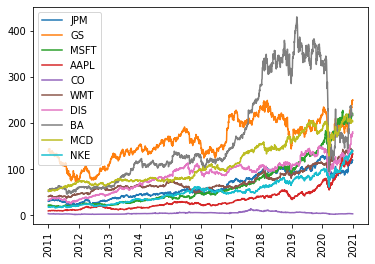

In [11]:
stocks = ["JPM", "GS", "V", "UNH", "CO"]

token = "NBQ7j3g_Q8_bcpvW6kMA"
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    try:
        wiki = WikipediaDataProvider(
            token=token,
            tickers=stocks,
            start=datetime.datetime(2011, 1, 1),
            end=datetime.datetime(2020, 12, 31),
        )
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")


if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")

if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")

for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()